In [63]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import astropy.units as u
import sys 
import os
sys.path.append("../src")
from regression import FrequentistRegression
# from scipy.optimize import curve_fit
params = {
         'axes.labelsize': 25,
         'axes.titlesize': 25,
         'ytick.labelsize' :25,
         'xtick.labelsize' :25,
         'legend.fontsize': 20,
         'xtick.major.size': 5,
         'xtick.minor.size': 4,
         'xtick.major.width': 3,
         'xtick.minor.width': 2,
         'ytick.major.size': 5,
         'ytick.minor.size': 4,
         'ytick.major.width': 3,
         'ytick.minor.width': 2,
         'ytick.color': "k",
         'xtick.color': "k",
         'axes.labelcolor': "k",
         'ytick.labelcolor' : "k",
         'xtick.labelcolor' : "k",
         'font.size': 20
         }
plt.rcParams.update(params)
plt.style.use('science')

# Folder directory for the figures of this notebook
figure_folder = r'C:/Users/noedi/Desktop/lab_optique/data/fibre_optique/'

## Semaine 1:
Objectifs de la semaine; 
- Caractérisation de la fibre multimode (ouverture numérique, V, nombre de modes)
- Caractérisation des deux fibres monomodes (ouverture numérique, V, nombre de modes).

On commence par la fibre multimode. Juste pour voir un peu mieux la photo du patron avec la fibre multimode, essayons de la mettre en espace logarithmique


In [64]:
image = plt.imread(figure_folder + "/check.jpg")
image.shape

(1536, 2048, 3)

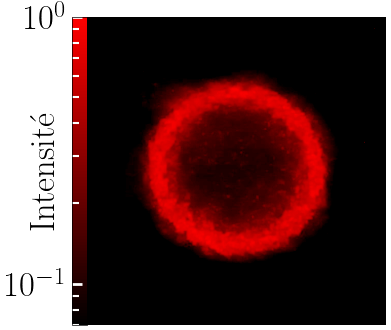

In [65]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm

fig, axs = plt.subplots(1, 1, figsize = (14, 4))
extent = 600
height, width, _ = image.shape
D = (height - extent+200)//2
U = (height + extent+200)//2
D_2 = (width - extent)//2
U_2 = (width + extent)//2


# Merci Stack Overflow (https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors)!
colors = [(0, 0, 0), (1, 0, 0)] 
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)

norm = LogNorm(vmin = 7e-2, vmax = 1, clip = True)
# norm=None
im = axs.imshow(image[D:U, D_2:U_2, 0] / image.max(), origin = "lower", cmap = cm, norm = norm) 
axs.axis("off")
# axs.annotate(r'$R$',xy=(0.5,0.52),xytext=(0.8,0.5), arrowprops={'arrowstyle': '<->', 'color': 'white'}, xycoords = 'axes fraction', color = "white", weight = 'bold')

cbar = plt.colorbar(im, fraction = 0.04, pad = -0.29)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.set_label("Intensité", labelpad = -40)
cbar.ax.tick_params(which = 'major', length = 7, width = 2, color = 'white')
cbar.ax.tick_params(which = 'minor', length = 5, width = 1.5, color = 'white')
# plt.savefig(figure_folder + 'photo_multimode_annotated.pdf', bbox_inches = 'tight')
plt.savefig(figure_folder + 'photo_multimode_no_annotate.pdf', bbox_inches = 'tight')

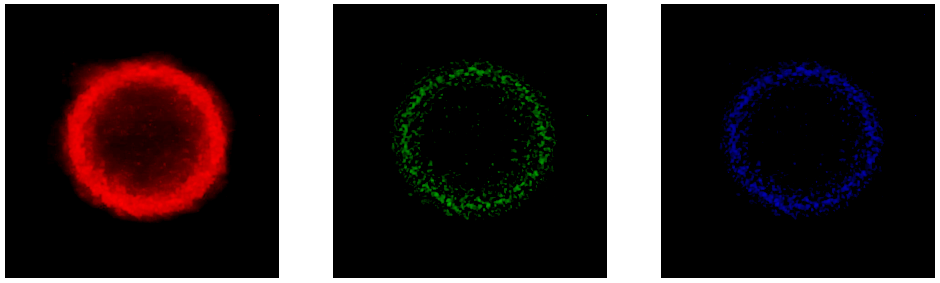

In [66]:
fig, axs = plt.subplots(1, 3, figsize = (12, 4))
extent = 600
height, width, _ = image.shape
D = (height - extent+200)//2
U = (height + extent+200)//2
D_2 = (width - extent)//2
U_2 = (width + extent)//2


# Merci Stack Overflow (https://stackoverflow.com/questions/57268627/matplotlib-color-gradient-between-two-colors)!
colors = [(0, 0, 0), (1, 0, 0)] 
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)
colors = [(0, 0, 0), (0, 1, 0)] 
cm1 = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)
colors = [(0, 0, 0), (0, 0, 1)] 
cm2 = LinearSegmentedColormap.from_list(
        "Custom", colors, N=100)
norm = LogNorm(vmin = 7e-2, vmax = 1, clip = True)
cms = [cm, cm1, cm2]
# norm=None
for i, ax in enumerate(axs):
        im = ax.imshow(image[D:U, D_2:U_2, i] / image[:, :, i].max(), origin = "lower", cmap = cms[i], norm = norm) 
        ax.axis("off")

On a réussi à créer du vert et du bleu avec un laser rouge :/ (portable bizarre?). 

### Fibre multimode
Notre premier objectif est de faire une régression linéaire pour les valeurs distance vs diamètre pour le patron vu sur l'écran. Définissons notre modèle linéaire comme suit: 
$$
y = \beta_0 + \beta_1 x \qquad \text{avec} \quad \begin{cases} y\equiv \text{Rayon du patron} \\  x\equiv\text{Distance de l'écran}\end{cases}
$$


In [67]:
# Importing the data
fname = figure_folder + r"multimode_mesures.txt"
data = np.loadtxt(fname, skiprows=1)
radius, distance = data[:, 0]/2, data[:, 1] # cm
sigma_radius, sigma_distance = 1e-1, 1e-1 # cm la demi-mesure la plus petite de la règle

# Définissons y et x pour la régression
x = distance 
y = radius 
sigma_x = sigma_distance
sigma_y = sigma_radius

Text(0, 0.5, 'Rayon [cm]')

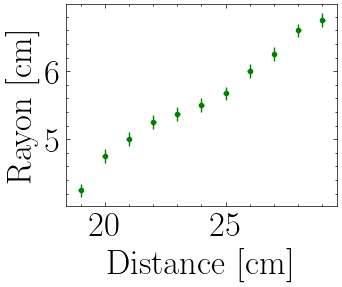

In [68]:
# Analyse préliminaire des données (sanity check)
plt.errorbar(distance, radius,  xerr = sigma_radius, yerr = sigma_distance, fmt = ".", color = "green")
plt.xlabel("Distance [cm]")
plt.ylabel("Rayon [cm]")

In [69]:
Regression_multimode = FrequentistRegression(
    degree = 1,
    sigma_noise = sigma_y
)


params_fitted, std_fitted = Regression_multimode.fit(
    obs = y, 
    x = x,
    ridge_reg = 1e-12,
    fit_intercept = True
)

y_pred = Regression_multimode.forward_model()
cov = Regression_multimode.cov
chi2 = Regression_multimode.compute_chi2(obs = y)

print("The parameters fitted are", params_fitted)
print("The std of the params fitted are", std_fitted)
print("The cov of the params fitted is", cov)
print("The chi squared is:", chi2)

The parameters fitted are [0.02909091 0.23136364]
The std of the params fitted are [0.23080885 0.00953463]
The cov of the params fitted is [[ 5.32727273e-02 -2.18181818e-03]
 [-2.18181818e-03  9.09090909e-05]]
The chi squared is: 1.187878787878784


Très bien, on a fait la régression, maintenant propageons les incertitudes sur les paramètres de régression dans notre modèle physique (i.e. notre modèle linéaire de régression ici). On a 
$$
\sigma_y = \sqrt{\sigma_{\beta_0}^2 + \sigma_{\beta_1}^2x^2 + \sigma_x^2 \beta_1^2}
$$

In [70]:
def model(x, params_fitted): 
    return params_fitted[0] + params_fitted[1] * x

def std_model(x, sigma_x, params_fitted, std_fitted):
    beta_0, beta_1 = params_fitted 
    std_beta0, std_beta1 = std_fitted 
    return np.sqrt(std_beta0 ** 2 + std_beta1 ** 2 * x **2 + sigma_x ** 2 * beta_1 ** 2) 


In [71]:
sigma_reg = std_model(x, sigma_x, params_fitted, std_fitted)
sigma_reg

array([0.29432329, 0.30028596, 0.30642932, 0.31274274, 0.31921611,
       0.32583992, 0.33260517, 0.33950341, 0.34652669, 0.35366756,
       0.36091905])

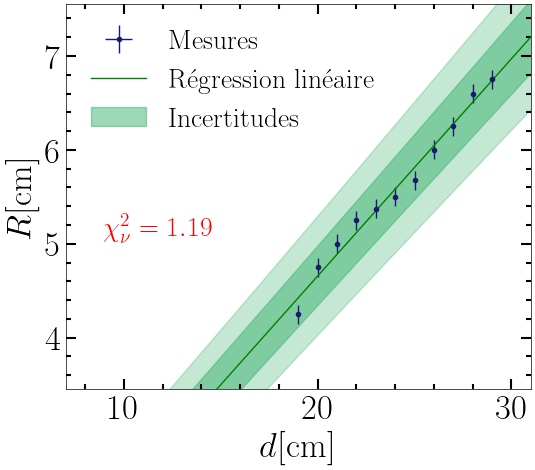

In [72]:
fig, axs = plt.subplots(1, 1, figsize = (6, 5))
ax = axs
x_fill = np.linspace(0, 50, 1000)
y_pred = model(x_fill, params_fitted) # prédiction du modèle de régression linéaire
std_reg = std_model(x_fill, sigma_x, params_fitted, std_fitted)
std_tot = np.sqrt(std_reg ** 2 + sigma_y ** 2)

# Mettre mesures et régression linéaire 
ax.errorbar(distance, radius,  xerr = sigma_radius, yerr = sigma_distance, fmt = ".", color = "midnightblue", label = "Mesures")
ax.plot(x_fill, y_pred, color = "green", label = "Régression linéaire")

# Première zone d'incertitude
k = 1
ax.fill_between(
    x = x_fill, 
    y1=y_pred - k * std_tot, 
    y2 = y_pred + k * std_tot, 
    color = "mediumseagreen",
    label = "Incertitudes", 
    alpha  = 0.5
)

k = 2
ax.fill_between(
    x = x_fill, 
    y1=y_pred - k * std_tot, 
    y2 = y_pred + k * std_tot, 
    color = "mediumseagreen",
    alpha  = 0.3
)

extent_x = 2
extent_y = 0.8
ax.set(xlim = [x.min()-extent_x - 10, x.max() + extent_x], ylim = [y.min() - extent_y, y.max() + extent_y], xlabel = r"$d$[cm]", ylabel = r"$R$[cm]")
ax.annotate(r"$\chi^2_\nu=%.2f$"%chi2, xy = (0.08, 0.4), xycoords = "axes fraction", color = "red", fontsize = 20)
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
ax.tick_params(which = 'major', axis = 'both', length = 7, width = 1.5)
ax.tick_params(which = 'minor', axis = 'both', length = 3.5, width = 1.5)
ax.legend(loc = "upper left", handles = [handles[idx] for idx in order], labels = [labels[idx] for idx in order])
# ax.legend()
plt.savefig(figure_folder + "multimode_regression.pdf", bbox_inches = 'tight')

In [73]:
3 * std_tot

array([0.75780747, 0.75780883, 0.75781288, 0.75781964, 0.75782911,
       0.75784128, 0.75785615, 0.75787373, 0.75789402, 0.757917  ,
       0.75794269, 0.75797108, 0.75800218, 0.75803598, 0.75807248,
       0.75811168, 0.75815358, 0.75819819, 0.75824549, 0.75829549,
       0.7583482 , 0.7584036 , 0.7584617 , 0.7585225 , 0.75858599,
       0.75865218, 0.75872107, 0.75879265, 0.75886693, 0.7589439 ,
       0.75902356, 0.75910591, 0.75919096, 0.75927869, 0.75936911,
       0.75946222, 0.75955802, 0.7596565 , 0.75975767, 0.75986152,
       0.75996806, 0.76007727, 0.76018917, 0.76030375, 0.760421  ,
       0.76054093, 0.76066354, 0.76078882, 0.76091677, 0.7610474 ,
       0.76118069, 0.76131666, 0.76145529, 0.76159658, 0.76174055,
       0.76188717, 0.76203646, 0.7621884 , 0.76234301, 0.76250027,
       0.76266018, 0.76282275, 0.76298797, 0.76315584, 0.76332636,
       0.76349952, 0.76367533, 0.76385378, 0.76403488, 0.76421861,
       0.76440498, 0.76459398, 0.76478562, 0.76497989, 0.76517

Propagation des incertitudes pour la fibre multimode: 

J'ignore ici l'ordonnée à l'origine puisqu'elle est à 1 ordre de grandeur en dessous... 
$$
NA = \sin\left( \arctan\left(\frac{R}{d}\right)\right)= \frac{R}{d\sqrt{\frac{R^2}{d^2}+1}}=\frac{R}{\sqrt{R^2 + d^2 }} = \frac{\beta_1}{\sqrt{\beta_1^2 + 1}}
$$
L'incertitude sur l'ouverture numérique est 
$$
\sigma_{NA} = \frac{\sigma_{\beta_1}}{(\beta_1^2 + 1)^{3/2}} =^{?} /frac{d}{\sqrt{\frac{R^2}{d^2}}}
$$

In [74]:
_, slope = params_fitted 
_, std_slope = std_fitted
na_exp = np.sin(np.arctan(slope))
print(na_exp)
# OU 
na_exp = slope / (np.sqrt(slope ** 2 + 1))
print(na_exp)

std_na = std_slope  / (slope**2 + 1) ** (3 / 2)

na_theo = 0.22
print(f"Ouverture numérique théorique égale à {na_theo:.2f}")  
print(f"Ouverture numérique expérimentale égale à {na_exp.item():.2f} +/- {std_na.item():.2f}")

0.22540929822077693
0.2254092982207769
Ouverture numérique théorique égale à 0.22
Ouverture numérique expérimentale égale à 0.23 +/- 0.01


In [75]:
slope

np.float64(0.2313636363636925)

On a perdu un 3 (holy molly). Calculons maintenant le nombre d'onde normalisé $V$

$$
V = \frac{2\pi a \times \text{NA}}{\lambda}
$$

Pour la fibre multimode, les valeurs de $a$ et de $\lambda$ sont connues (on va assumer que l'incertitude est négligeable par rapport à celle de l'ouverture numérique). Donc, on a seulement besoin de propager l'incertitude expérimentale liée à l'ouverture numérique, on obtient simplement 
$$
\sigma_{V} = \frac{2\pi a \times \sigma_\text{NA}}{\lambda}
$$

In [76]:
def compute_V(radius, numerical_aperture, wavelength=632.8 * 1e-9):
    return 2 * np.pi * radius * numerical_aperture / wavelength


a = 52.5 * 1e-6 # m
red_lambda = 632.8 * 1e-9 # m
V_theo = compute_V(radius = a, numerical_aperture = na_theo, wavelength = red_lambda)
V_exp = compute_V(radius = a, numerical_aperture = na_exp, wavelength = red_lambda)
std_V = compute_V(radius = a, numerical_aperture = std_na, wavelength = red_lambda)
print(f"Le nombre d'onde normalisé théorique est {V_theo:.3g}")
print(f"Le nombre d'onde normalisé expérimental est {V_exp:.3g} +/- {std_V:.0f}")

Le nombre d'onde normalisé théorique est 115
Le nombre d'onde normalisé expérimental est 118 +/- 5


Finalement, le nombre de mode peut être calculé comme (pour les deux directions de polarisations, perpendiculaires à l'axe de la fibre optique)
$$
N_{mode} \approx \frac{V^2}{2}
$$



In [77]:
def compute_N(V):
    return V ** 2 / 2

def compute_std_N(V, std_V):
    return 2 * V * std_V

N_theo = compute_N(V_theo)
N_exp = compute_N(V_exp)
std_N = compute_std_N(V_exp, std_V)
print(f"Le nombre de modes théorique est {int(N_theo):.2g}")
print(f"Le nombre de modes expérimental est {int(N_exp):.2g} +/- {std_N:.2g}")

Le nombre de modes théorique est 6.6e+03
Le nombre de modes expérimental est 6.9e+03 +/- 1.1e+03


Préparation pour la semaine 2: 
Avant de passer aux mesures sur les fibres monomodes, commençons par calculer les différentes valeurs possibles théoriques de nombre d'onde normalisé pour chaque fibre monomode

In [78]:
class Fiber: 
    def __init__(self, name, radius, numerical_aperture):
        self.radius = radius # rayon du coeur (meters)
        self.numerical_aperture = numerical_aperture # ouverture numérique (sans unité)
        self.name = name

    def compute_V(self, wavelength): 
        return 2 * np.pi * self.radius * self.numerical_aperture / wavelength
    
    def compute_N(self, wavelength):
        V = self.compute_V(wavelength)
        return V ** 2 / 2

    def compute_std_N(self, wavelength, std_V):
        V = self.compute_V(wavelength)
        return 2 * V * std_V
    
    def print_properties(self): 
        print(f'Rayon du coeur vaut: {self.radius * 1e6:.3g} micro-mètres')
        print(f'Ouverture numérique vaut: {self.numerical_aperture:.2g}')

    def print_wavelength_properties(self, wavelength):
        print(f"Nombre d'onde normalisé vaut: {self.compute_V(wavelength):.2g}")
        print(f"Nombre de modes {self.compute_N(wavelength):.2g}")

In [79]:
if np.ones(1): 
    print("hey")

hey


In [80]:
fiber1 = Fiber(name = "Fiber 1", radius = 1.75 * 1e-6, numerical_aperture=0.13)
fiber2 = Fiber(name = "Fiber 2", radius = 2.2 * 1e-6,  numerical_aperture=0.13)
fiber3 = Fiber(name = "Fiber 3", radius = 1.8 * 1e-6,  numerical_aperture=0.2)

wavelengths = {"red": 632.8 * u.nanometer, "green": 532 * u.nanometer, "blue": 402.5* u.nanometer}
fibers = [fiber1, fiber2, fiber3]

for fiber in fibers:
    print(f'PROPERTIES FOR FIBER MONOMODE {fiber.name}') 
    fiber.print_properties()
    for color in list(wavelengths.keys()):
        print(f"Laser {color}")
        fiber.print_wavelength_properties(wavelengths[color].to(u.meter).value)
        print()
    print()
    print()

PROPERTIES FOR FIBER MONOMODE Fiber 1
Rayon du coeur vaut: 1.75 micro-mètres
Ouverture numérique vaut: 0.13
Laser red
Nombre d'onde normalisé vaut: 2.3
Nombre de modes 2.6

Laser green
Nombre d'onde normalisé vaut: 2.7
Nombre de modes 3.6

Laser blue
Nombre d'onde normalisé vaut: 3.6
Nombre de modes 6.3



PROPERTIES FOR FIBER MONOMODE Fiber 2
Rayon du coeur vaut: 2.2 micro-mètres
Ouverture numérique vaut: 0.13
Laser red
Nombre d'onde normalisé vaut: 2.8
Nombre de modes 4

Laser green
Nombre d'onde normalisé vaut: 3.4
Nombre de modes 5.7

Laser blue
Nombre d'onde normalisé vaut: 4.5
Nombre de modes 10



PROPERTIES FOR FIBER MONOMODE Fiber 3
Rayon du coeur vaut: 1.8 micro-mètres
Ouverture numérique vaut: 0.2
Laser red
Nombre d'onde normalisé vaut: 3.6
Nombre de modes 6.4

Laser green
Nombre d'onde normalisé vaut: 4.3
Nombre de modes 9

Laser blue
Nombre d'onde normalisé vaut: 5.6
Nombre de modes 16





## Semaine 2
On commence par un peu de théorie de propagation des modes pour la fibre optique. Je me fie à deux sources principales:
- [Ce site web](https://www.rp-photonics.com/lp_modes.html); 
- Le livre _Spatial Optical-Fiber Coupling Technology in Optical-Wireless Communication_ de Xizheng Ke.

On va étudier théoriquement l'aspect du champ électrique à un temps $t$ fixe et en prenant une section (imaginaire) de la fibre optique. Pour simplifier grandement les choses, on se place dans un système de coordonnées cylindriques et on place notre axe des $z$ comme étant l'axe au centre du cylindre que forme la fibre optique. 

Trouver le champ électrique $\mathbf{E}(r,\phi)$ (j'ignore ici les variables $z$ et $t$ puisqu'on les maintient fixes) revient à résoudre l'équation de Helmholtz (qui peut être dérivée des équations de Maxwell dans la matière)
$$
\nabla^2 \mathbf{E} + k^2 \mathbf{E} = 0\, .
$$

L'équation de Helmoltz est un cas spécifique du problème de Sturm-Liouville qui peut être solutionné en coordonnées cylindriques analytiquement. En première approximation, on peut assumer que la composante $z$ du champ électrique est nulle et on peut solutionner pour un champ scalaire $\Psi(r, \phi)$. 
$$
E_{z} = \cos(l\phi)\begin{cases} J_{l}(u_{lm}\frac{r}{r_{coeur}})& \quad r<r_{coeur} \\ K_{l}(w_{lm}\frac{r}{r_{coeur}}) & \quad r>r_{coeur}\end{cases}
$$
où
- $J_{lm}$ correspond à la fonction de Bessel de première espèce
- $K_{lm}$ correspond à la fonction de _Bessel modifiée_ de second espèce.
- $u_{lm}$ et $w_{lm}$ sont les -mièmes racines des deux fonctions mentionnées précédemment. Physiquement, ces racines sont déterminées par les relations suivantes
$$
\begin{align}
u_{lm} = r_{coeur}\sqrt{n_{coeur}^2k^2 - \beta^2}
\end{align}
$$
Par conséquent, les relations entre les différentes caractéristiques de la fibre vont déterminer le couple $(l,m)$ pour le mode LP. Changer l'alignement va revenir à changer l'équation ci-dessous. Dans notre cas, on veut avoir $(u_{01}, w_{01})$ pour les fibres monomodes. 

Faisons tout d'abord des figures des fonctions de Bessel qui sont introduites ci-dessus.


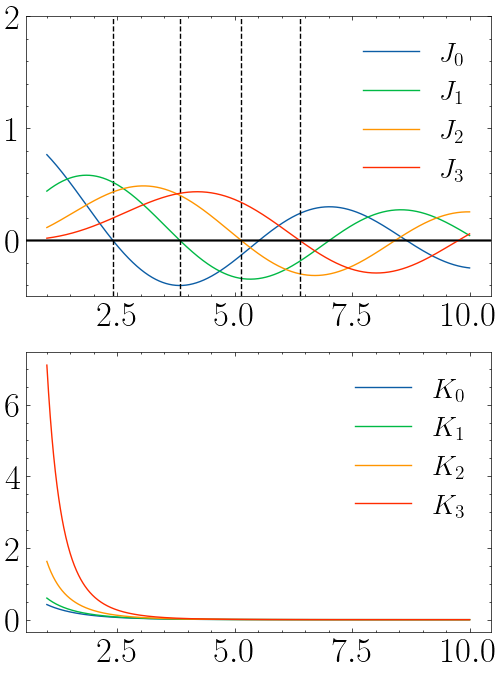

In [81]:
from scipy.special import jv, jn_zeros, kn # Bessel function and its roots

ls = np.arange(0, 4)
x = np.linspace(1, 10, 1000)
fig, axs = plt.subplots(2, 1, figsize = (6, 8))


for l in ls: 
    axs[0].plot(x, jv(l, x), label = r"$J_{%d}$"%l)
    axs[0].axvline(jn_zeros(l, 1)[0], color = 'k', ls = 'dashed')
    axs[0].axhline(0, color = 'k')
    axs[0].set(ylim = [-0.5, 2])
    axs[0].legend()
    axs[1].plot(x, kn(l, x), label = r"$K_{%d}$"%l)
    axs[1].legend()

In [82]:
jn_zeros(0, 1)

array([2.40482556])

Parfait. On remarque que la fonction de Bessel modifié tend vers 0 très rapidement; ceci est normal puisqu'on se trouve dans la gaine de la fibre optique, là où l'onde est censé être parfaitement réfléchie ! On a ce qu'on appelle une onde évanescente en mécanique quantique. Pour le reste de l'analyse, on va simplement assumer que notre seconde condition est 0 pour $r>r_{coeur}$. 

Créons maintenant le code pour afficher sur une grille de pixels la composante $E_z$ du champ électrique. Ça va nous demander de faire un meshgrid et de calculer $E_z$ pour chaque valeur de la grille. 

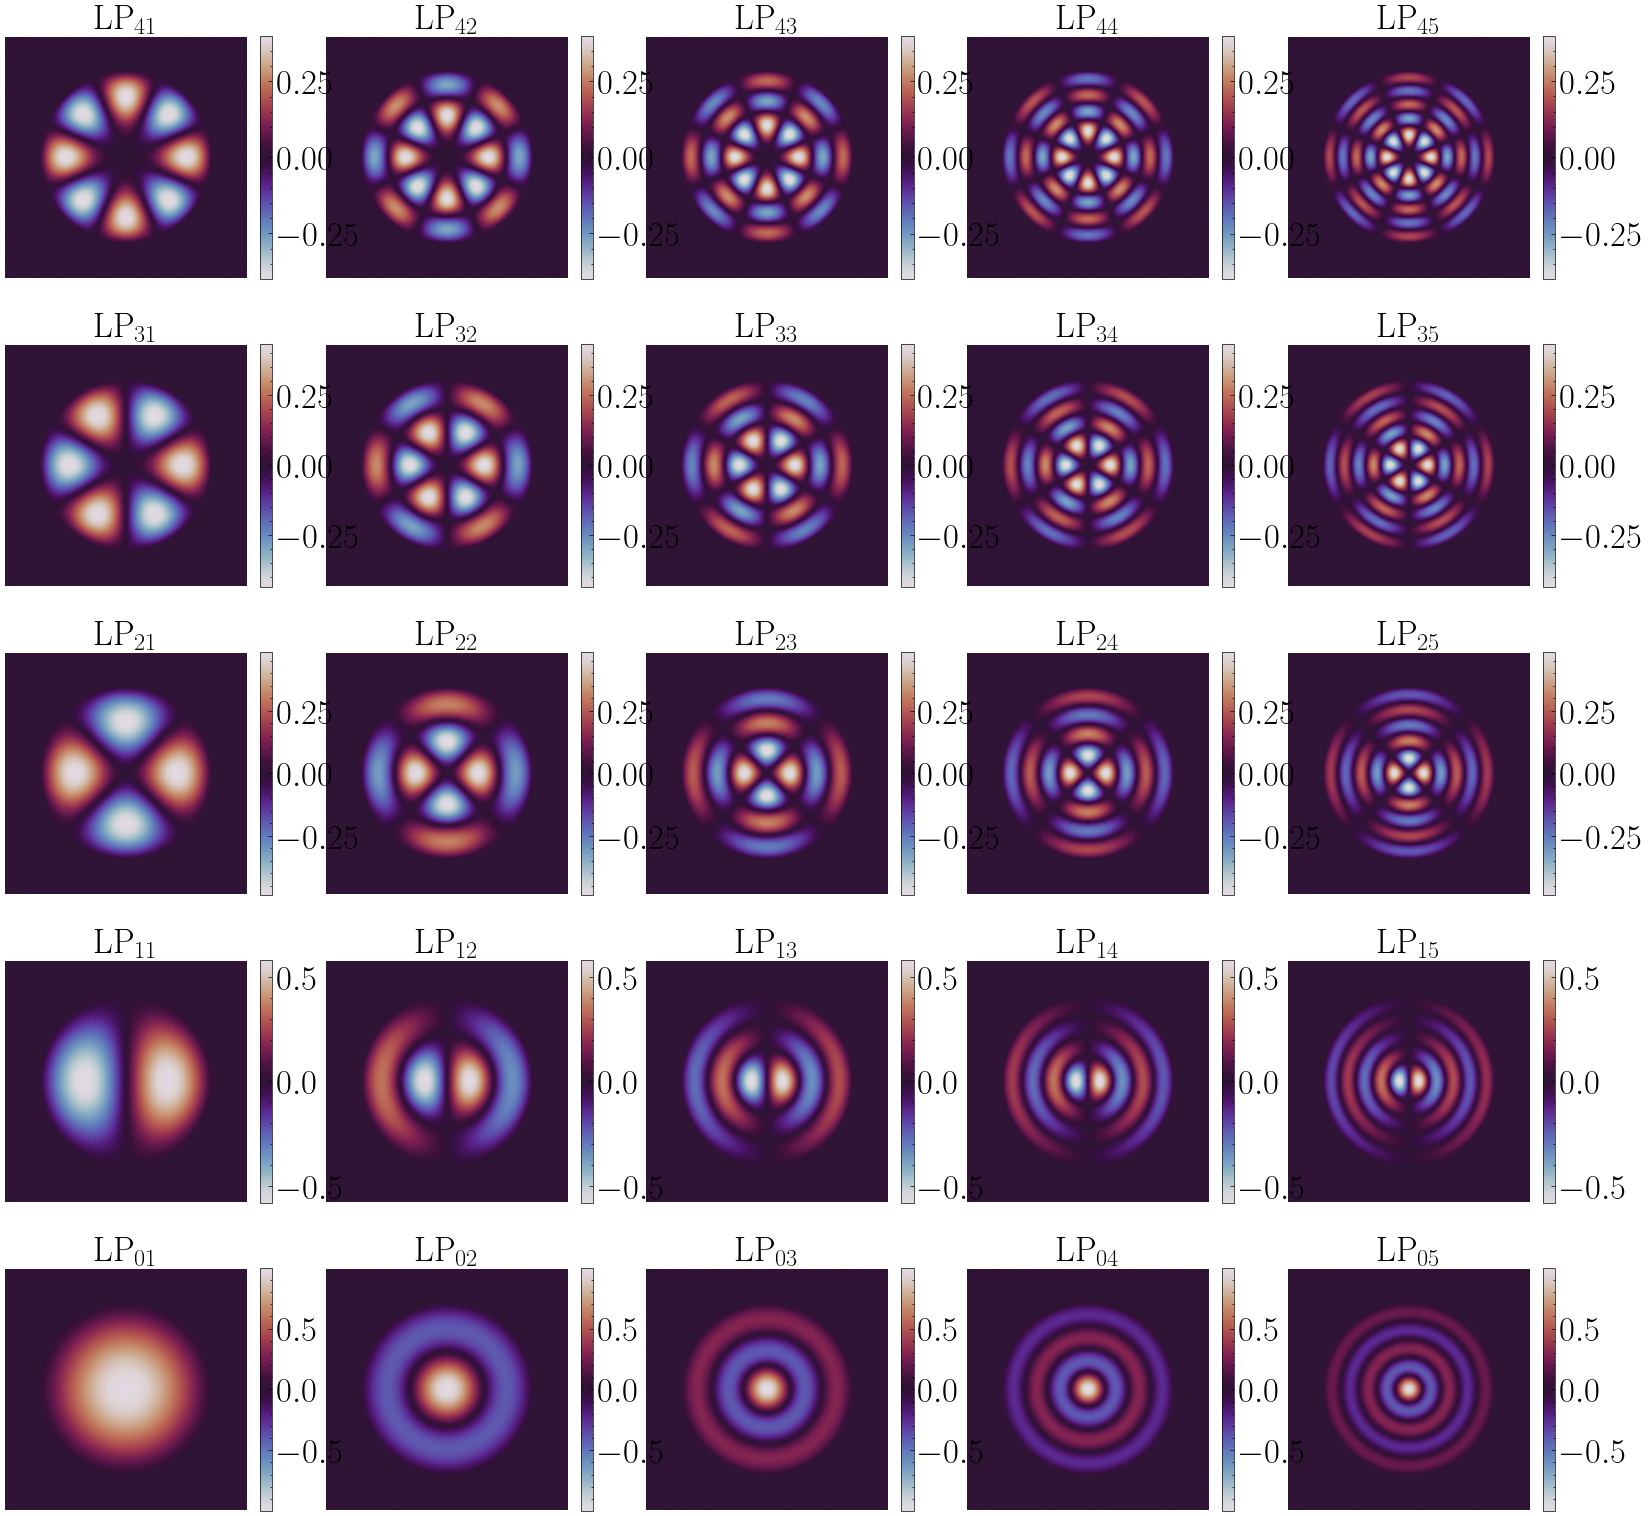

In [97]:
grid_size = 512 
r_max = 0.5 # micro mètres  
extent = 1.4 * r_max
x = np.linspace(-extent, extent, grid_size)
y = np.linspace(-extent, extent, grid_size)
X, Y = np.meshgrid(x, y)

R = np.sqrt(X**2 + Y**2)
PHI = np.arctan2(Y, X)

def lp_mode(l, m, R, PHI, r_max):
    roots = jn_zeros(l, m) 
    u_lm = roots[m-1]  # m-1 à cause du zero-indexing
    return jv(l, u_lm * R / r_max) * np.cos(l * PHI) * (R <= r_max) # la dernière multiplication mets à 0 les rayons supérieures au rayon de coeur. 

nrows, ncols = 5, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

ax = ax[::-1, :]
for l in range(nrows):
    for m in range(1, ncols+1):
        mode_field = lp_mode(l, m, R, PHI, r_max)
        
        intensity = mode_field ** 2
        norm = LogNorm(vmin = 1e-3, vmax =intensity.max(), clip = True)
        norm = None
        im = ax[l, m-1].imshow(mode_field, extent=(-r_max, r_max, -r_max, r_max), origin='lower', cmap='twilight', vmin = -abs(mode_field.max()), vmax = abs(mode_field.max()))
        plt.colorbar(im, fraction = 0.0455)
        ax[l, m-1].set_title(r"$\mathrm{LP}_{%d %d}$"%(l,m))
        ax[l, m-1].set_xlabel('x (arbitrary units)')
        ax[l, m-1].set_ylabel('y (arbitrary units)')
        ax[l, m-1].axis("off")

plt.subplots_adjust(wspace = 0.2, hspace = 0.)
# plt.savefig("LP_lm_modes.pdf", bbox_inches = 'tight')


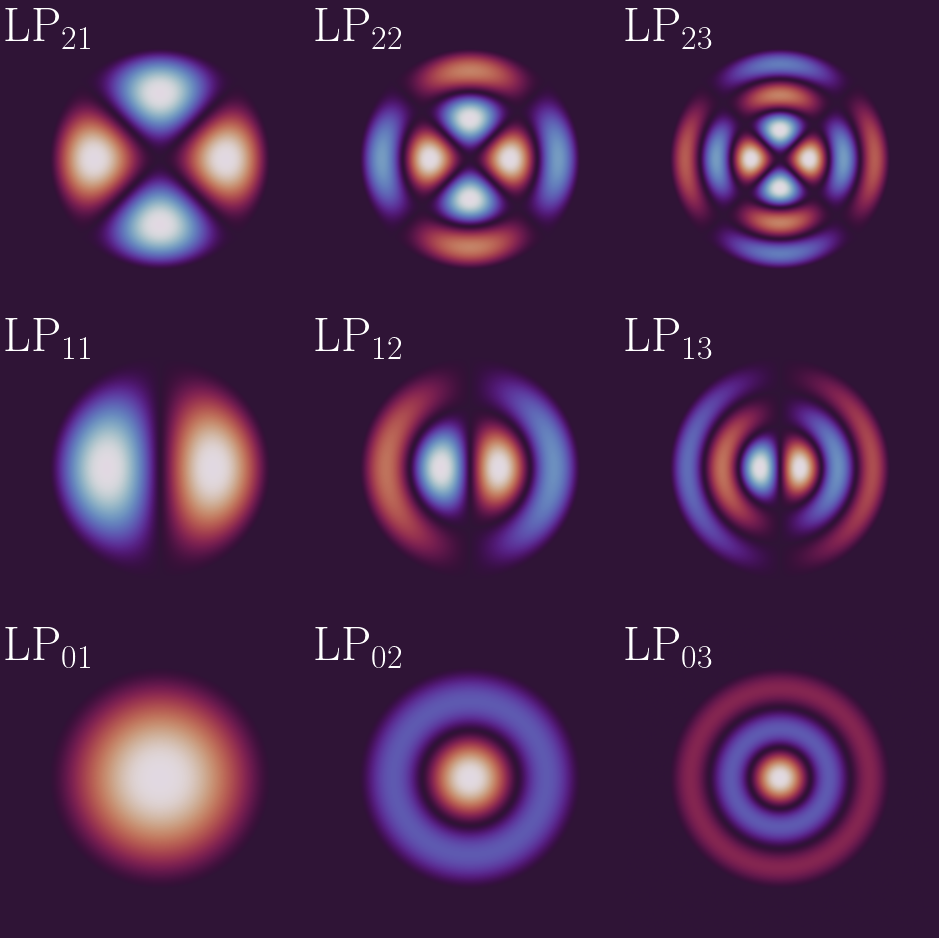

In [98]:
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4.02))

ax = ax[::-1, :]
for l in range(nrows):
    for m in range(1, ncols+1):
        mode_field = lp_mode(l, m, R, PHI, r_max)
        
        intensity = mode_field ** 2
        norm = LogNorm(vmin = 1e-3, vmax =intensity.max(), clip = True)
        norm = None
        im = ax[l, m-1].imshow(mode_field, extent=(-r_max, r_max, -r_max, r_max), origin='lower', cmap='twilight', vmin = -abs(mode_field.max()), vmax = abs(mode_field.max()))
        ax[l, m-1].annotate(r"LP$_{%d %d}$"%(l, m), xy = (0.0, 0.88), color = 'white', xycoords = 'axes fraction', fontsize = 35)
        ax[l, m-1].axis("off")

zero_color = plt.get_cmap("twilight")(0.5)
fig.set_facecolor(color = zero_color)
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.savefig(figure_folder + "LP_lm_modes.pdf", bbox_inches = 'tight')

In [85]:
(R <= r_max)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [86]:
X[0]

array([-0.6       , -0.59765166, -0.59530333, -0.59295499, -0.59060665,
       -0.58825832, -0.58590998, -0.58356164, -0.58121331, -0.57886497,
       -0.57651663, -0.5741683 , -0.57181996, -0.56947162, -0.56712329,
       -0.56477495, -0.56242661, -0.56007828, -0.55772994, -0.5553816 ,
       -0.55303327, -0.55068493, -0.54833659, -0.54598826, -0.54363992,
       -0.54129159, -0.53894325, -0.53659491, -0.53424658, -0.53189824,
       -0.5295499 , -0.52720157, -0.52485323, -0.52250489, -0.52015656,
       -0.51780822, -0.51545988, -0.51311155, -0.51076321, -0.50841487,
       -0.50606654, -0.5037182 , -0.50136986, -0.49902153, -0.49667319,
       -0.49432485, -0.49197652, -0.48962818, -0.48727984, -0.48493151,
       -0.48258317, -0.48023483, -0.4778865 , -0.47553816, -0.47318982,
       -0.47084149, -0.46849315, -0.46614481, -0.46379648, -0.46144814,
       -0.4590998 , -0.45675147, -0.45440313, -0.45205479, -0.44970646,
       -0.44735812, -0.44500978, -0.44266145, -0.44031311, -0.43

In [87]:
Y.shape

(512, 512)

In [26]:
intensity.min()

np.float64(0.0)